# Приоритизиция гипотез, запуск A/B-теста и анализ результатов

Вместе с отделом маркетинга крупного интернет-магазина подготовлен список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters

Откроем файлы, ознакомимся с ними и подготовим их к дальнейшей работе:

In [2]:
# функция для чтения файла локально и на сервере школы

def read_csv(file):
    file = 'datasets/' + file + '.csv'
    try:
        return pd.read_csv('/' + file)
    except FileNotFoundError:
        return pd.read_csv(file)

In [3]:
hypothesis = read_csv('hypothesis')
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Девять гипотез, и все поля по ним заполнены. Можно работать. Проверим типа данных:

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Проверим данные файла 'orders', при изначальной проверке типа данных, колонка 'date' имела несоответствующий тип данных, исправим это:

In [5]:
orders = read_csv('orders')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [6]:
# проверка
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Сделаем проверку на дубликаты и пропуски:

In [7]:
orders.duplicated().sum()

0

In [8]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Проверим размеры групп и их отношение: 

In [9]:
ordersA = orders[orders['group']=='A']
ordersB = orders[orders['group']=='B']

print(ordersA.shape, ordersB.shape)
print('Разница: ', "{:.2%}".format((640/557)-1))

(557, 5) (640, 5)
Разница:  14.90%


In [10]:
ordersA.shape[0]

557

Разница в размерах групп дает меньшую статистическую мощность теста. Проверим распределение пользователей по группам, один пользователь должен принадлежать только одной группе на протяжении всего теста.

Проверим не попал ли один и тот же участник в обе группы:

In [11]:
# считаем для каждого посетителя количество групп
ab_orders = orders.groupby('visitorId', as_index=False).agg({'group':'nunique'})

# считаем кол-во пользователей с 1 и 2 группами
ab_orders = ab_orders.groupby('group', as_index=False).agg({'visitorId':'count'})
ab_orders.columns = ['group_count', 'users']
ab_orders

,group_count,users
0,1,973
1,2,58


Получается, что 58 пользователей одновременно находятся в обеих группах. Такого быть не должно - может исказить результаты. Удалим их из выборки.

In [12]:
# считаем для каждого посетителя количество групп
ab_visitors = orders.groupby('visitorId', as_index=False).agg({'group': 'nunique'})

# берем только тех, у кого две группы
ab_visitors = ab_visitors.query('group==2')

# берем список из двойных посетителей
ab_visitors = ab_visitors['visitorId']

# получаем маску всех заказов двойных посетителей
ab_orders = orders['visitorId'].isin(ab_visitors)

# выбираем тех, кто только в одной группе по инвертированной маске
orders = orders[~ab_orders]

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


In [14]:
# проверка
ab_orders = orders.groupby('visitorId', as_index=False).agg({'group':'nunique'})
ab_orders = ab_orders.groupby('group', as_index=False).agg({'visitorId':'count'})
ab_orders.columns = ['group_count', 'users']
ab_orders

,group_count,users
0,1,973


Теперь все верно, все пользователи имеют только одну группу.

Проверим размеры групп и их отношение после очистки данных:

In [15]:
ordersA = orders[orders['group']=='A']
ordersB = orders[orders['group']=='B']

print(ordersA.shape, ordersB.shape)
print('Разница: ', "{:.2%}".format((548/468)-1))

(468, 5) (548, 5)
Разница:  17.09%


Проверим данные файла 'visitors', при изначальной проверке типа данных, колонка 'date' имела несоответствующий тип данных, исправим это:

In [16]:
visitors = read_csv('visitors')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [17]:
# проверка
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Сделаем проверку на дубликаты и пропуски:

In [18]:
visitors.duplicated().sum()

0

In [19]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

## Приоритизация гипотез.

В файле hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.


**Задача**

- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

ICE = (Impact * Confidence) / Efforts 

RICE = (Reach * Impact * Confidence) / Efforts 

In [20]:
pd.set_option('max_colwidth', 150)

hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis['ICE'] = hypothesis['ICE'].round(2)

hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


После применения фреймворка ICE, самыми приоритетными явдяются гипотезы 8, 0 и 7. Посмотрим какие результаты мы получим при расчете по RICE:

In [21]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Применив фреймворк RICE, позиции поменялись: гипотезы 7, 2, 0 и 6 заняли топовые места.

Изменения произошли из-за дополнительного фактора - 'Reach' - охвата аудитории, которых коснутся изменения. Так седьмая гипотеза поднялась на первое место с третьего. А восьмая, наоборот, упала аж до пятой позиции. 

Маркетинговой команде определенно можно советовать добавление формы подписки на основные страницы и добавление двух новых каналов привлечения трафика.

## Анализ A/B-теста

A/B-тест проведен и получены результаты, которые описаны в файлах orders.csv и visitors.csv.

#### Задача

Проанализируем A/B-тест:

- Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

In [22]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [23]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [24]:
# создаем массив уникальных пар значений дат и групп теста

datesGroups = orders[['date','group']].drop_duplicates()
datesGroups

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


Агрегируем значения. Построчно для каждой группы (А и В) для каждой даты рассчитаем кумулитивное количество транзакций и покупателей.

In [25]:
ordersAggregated = datesGroups.apply\
    (lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, \
          'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

ordersAggregated

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854
...,...,...,...,...,...
533,2019-08-29,B,510,490,4746610
757,2019-08-30,A,460,437,3311413
690,2019-08-30,B,531,511,4955833
958,2019-08-31,A,468,445,3364656


То же самое сделаем для файла с посетителями.

In [26]:
visitorsAggregated = datesGroups.apply\
    (lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
     .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
    .sort_values(by=['date','group'])

visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [27]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], \
                                        right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


In [28]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням 
# в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

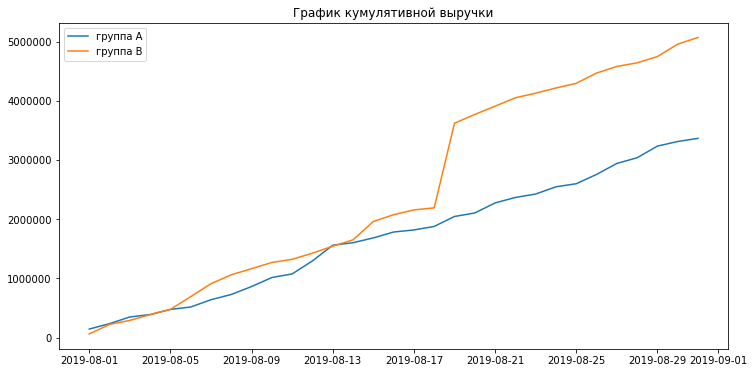

In [29]:
plt.figure(figsize=(12,6))

# строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.ticklabel_format(style='plain', axis='y')

plt.title('График кумулятивной выручки')
plt.legend(['группа А', 'группа В'])
plt.show()

В самом начале теста обе группы показывали практически одинаковые результаты, но с примерно второй недели теста группа В выросла в показателях. В какой-то момент обе группы сравнялись, но затем группа В снова поднялась. Также в группе B был резкий скачок, который увеличил разницу между группами, которая до скачка была не такой драматичной.

Возможно, в группе В был аномально дорогой(ие) заказ(ы) или количество самих заказов сильно больше по сравнению с группой А, которые увеличили кумулятивную выручку. Есть шансы того, что группы различаются не сильно на самом деле.

- Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

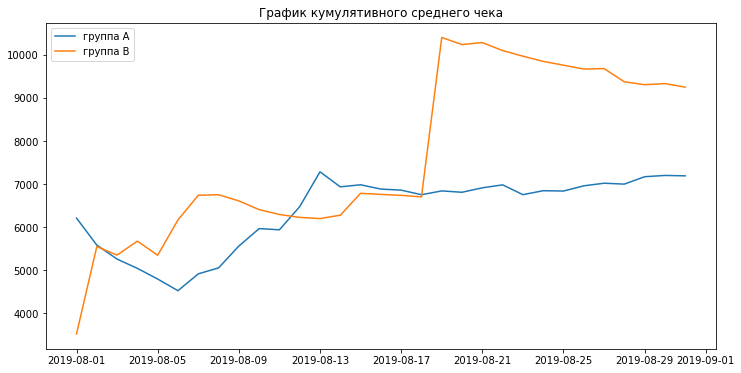

In [30]:
plt.figure(figsize=(12,6))

# строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

# строим график среднего чека группы В
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.ticklabel_format(style='plain', axis='y')

plt.title('График кумулятивного среднего чека')
plt.legend(['группа А', 'группа В'], loc = 'upper left')

plt.show()

Графики обоих групп по кумулитивному среднему чеку очень сильно скачут и устанавливаются только третьей неделе теста. Снова наблюдается резкий скачок для группы В во второй половине теста - скорее всего это тот самый аномально дорогой заказ. 

Мы по-прежнему не можем судить о различиях двух групп, так как средний чек группы В мог быть сильно искажен аномальным заказом.

- Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

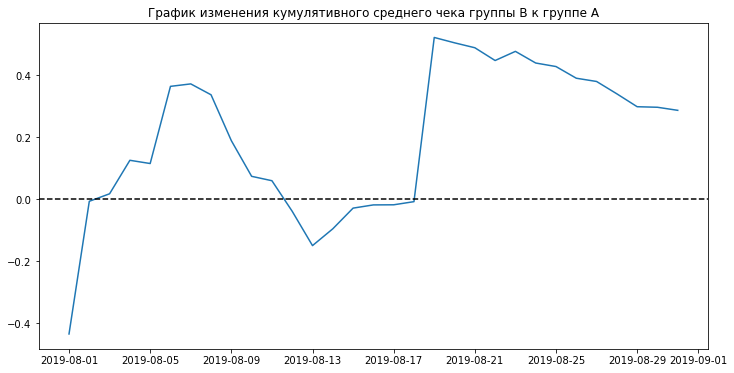

In [31]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,6))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], \
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']) - 1)

plt.title('График изменения кумулятивного среднего чека группы В к группе А')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

В нескольких точках график резко скачет. Пока мы не можем с уверенностью делать какие-либо выводы. Необходимо отсеять выбросы.

- Построим график кумулятивной конверсии по группам. Сделаем выводы и предположения.

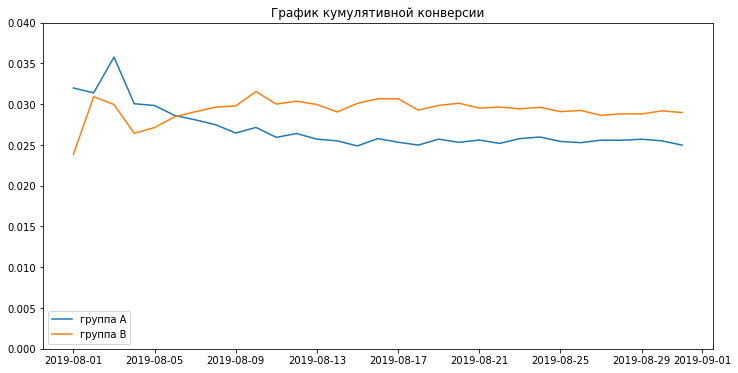

In [32]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12,6))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.title('График кумулятивной конверсии')
plt.legend(['группа А', 'группа В'], loc = 'lower left')

# задаем масштаб осей
plt.axis([None, None, 0, 0.04])

plt.show()

Обе группы колебались вначале, но затем конверсия группы В вырвалась вперед, и значения обоих групп зафиксировались. После чего группа В показывала стабильно лучшие результаты.

- Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделаем выводы и предположения.

In [33]:
# соединим данные по конверсии групп А и В 

mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
    .merge(cumulativeDataB[['date','conversion']], on='date', suffixes=['A', 'B'])

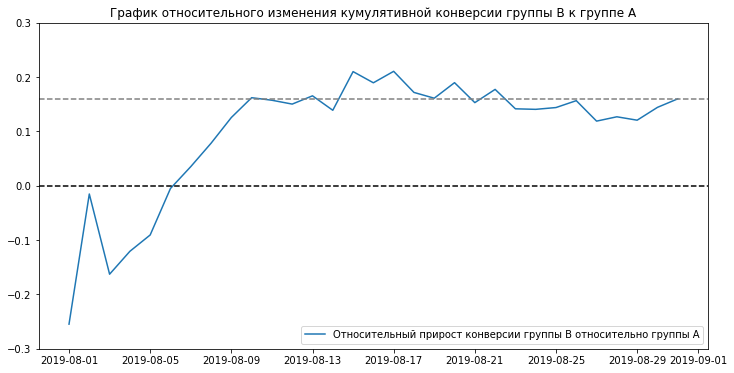

In [34]:
plt.figure(figsize=(12,6))

plt.plot(mergedCumulativeConversions['date'], \
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, \
         label="Относительный прирост конверсии группы B относительно группы A")

plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.16, color='grey', linestyle='--')
plt.axis([None, None, -0.3, 0.3]) 

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.legend(loc = 'lower right')

plt.show()

В начале теста снова наблюдаются колебания, но уже со второй недели теста конверсия группы В значительно выше группы А. Нам потребуется изучить аномалии перед тем, как мы сможем делать выводы.

- Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.

In [35]:
# подсчитаем количество заказов по пользователям

ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).\
    agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['visitorId','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Есть пользователи, которые сделали 5, 8, 9 и даже 11 заказов. Построим график распределения количества заказов на одного пользователя.

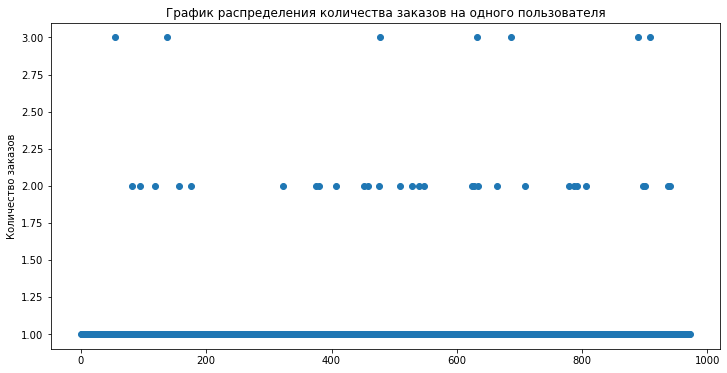

In [36]:
# количество покупателей
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(12,6))

plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('Количество заказов')

plt.title('График распределения количества заказов на одного пользователя')
plt.show()

Подавляющее большинство делают 1 заказ на человека. Много пользователей с 2-3 заказами, но их точная доля не ясна — непонятно, считать их аномалиями или нет.

- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберим границу для определения аномальных пользователей.

In [37]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 1., 2.])

Не более 1% пользователей оформляли больше чем 2 заказа. Разумно выбрать 1 или 2 заказов на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

- Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

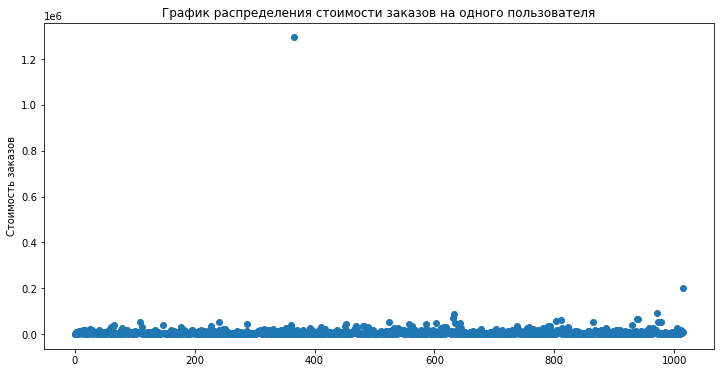

In [38]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(12,6))

plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказов')

plt.title('График распределения стоимости заказов на одного пользователя')
plt.show()

Из графика явно видно, что есть один явный выброс стоимостью более миллиона. Рассмотрим график поближе, установив верхнюю границу возле 250,000 - это позволит оценить распределение большинства заказов.

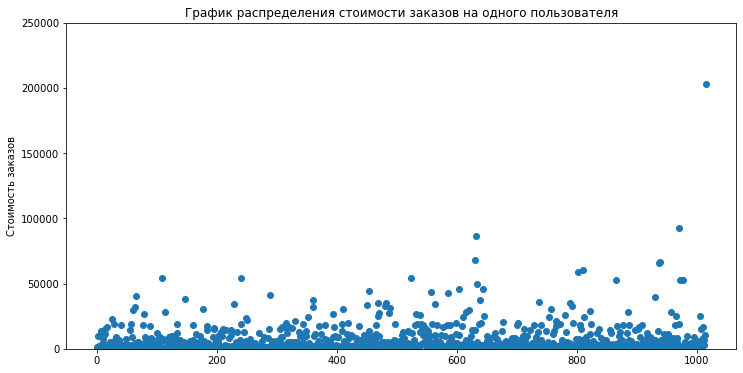

In [39]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(12,6))

plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказов')

# график имеет один выброс стоимостью более миллиона
# поставим границу, чтобы рассмотреть основные значения детальнее
plt.ylim([0, 250000]) 

plt.title('График распределения стоимости заказов на одного пользователя')
plt.show()

Есть немного дорогих заказов, один даже в более чем 1,2 млн. По графику можно выбрать границу аномальных заказов между 50 000 и 100 000. Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями. Посчитаем эти значения, так как по графику трудно судить о процентном соотношении таких заказов.


- Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберим границу для определения аномальных заказов.

In [40]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

Меньше 5% сделали заказы на более 26,785, и только 1% покупателей - сверх 53,904. Обозначим нормальными заказами те, что не дороже 26,785.


- Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Сделаем выводы и предположения.



In [41]:
# подготовка данных

# пользователи группы А по дням
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# кумулятивное кол-во пользователей группы А
visitorsACummulative = visitorsADaily.apply(lambda x: \
                                            visitorsADaily[visitorsADaily['date'] <= x['date']]\
                                            .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# пользователи группы В по дням
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# кумулятивное кол-во пользователей группы В
visitorsBCummulative = visitorsBDaily.apply(lambda x: \
                                            visitorsBDaily[visitorsBDaily['date'] <= x['date']]\
                                            .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [42]:
# заказы и выручка группы А по дням
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})

ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# кумулятивные заказы и выручка группы А
ordersACummulative = ordersADaily.apply(lambda x:\
                                        ordersADaily[ordersADaily['date'] <= x['date']]\
                                        .agg({'date' : 'max','ordersPerDateA' : 'sum',\
                                              'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])

ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [43]:
# заказы и выручка группы В по дням
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# кумулятивные заказы и выручка группы В
ordersBCummulative = ordersBDaily.apply(lambda x: \
                                        ordersBDaily[ordersBDaily['date'] <= x['date']]\
                                        .agg({'date' : 'max','ordersPerDateB' : 'sum',\
                                              'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])

ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']


In [44]:
# соединим все данные в одну таблицу

data = ordersADaily.merge(ordersBDaily, on='date')\
    .merge(ordersACummulative, on='date')\
    .merge(ordersBCummulative, on='date')\
    .merge(visitorsADaily, on='date')\
    .merge(visitorsBDaily, on='date')\
    .merge(visitorsACummulative, on='date')\
    .merge(visitorsBCummulative, on='date')

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Посчитаем статистическую значимость различия в конверсии между группами.


In [45]:
# посчитаем кол-во заказов для пользователей, совершивших хотя бы один заказ

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique})

ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique})

ordersByUsersB.columns = ['visitorId', 'orders']

In [46]:
# посчитаем тех, кто не сделал заказы
just_visitors = data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])

# поставим нули для такого количества пользователей
sampleA = pd.concat([ordersByUsersA['orders'],\
                     pd.Series(0, index=np.arange(just_visitors), name='orders')],axis=0)

just_visitors = data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])

sampleB = pd.concat([ordersByUsersB['orders'],\
                     pd.Series(0, index=np.arange(just_visitors), name='orders')],axis=0)

Сделаем проверку критерием Манна-Уитни. Также, выведем относительный прирост конверсии группы B.

In [47]:
# создадим функцию для расчета теста, а также различия в средних

def show_stats(a, b, title):
    print(f'P-value: {stats.mannwhitneyu(a, b, alternative="two-sided")[1]:.3f}')
    print(f'Относительный прирост {title} группы B: {b.mean() / a.mean() - 1:.3F}')

**Нулевая гипотеза:** конверсии групп А и В _не имеют_ статистически значимых различий.

**Альтернативаня гипотеза:** конверсии групп А и В _имеют_ статистически значимые различия.

In [48]:
show_stats(sampleA, sampleB, 'конверсии')

P-value: 0.011
Относительный прирост конверсии группы B: 0.160


P-value = 0.011, т.е. меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный выигрыш группы В равен 16%. Стоит посмотреть как повлияет отсеивание аномалий, мы нашли несколько особо активных покупателей.

- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

Также найдём относительные различия в среднем чеке между группами.

**Нулевая гипотеза:** средние чеки групп А и В _не имеют_ статистически значимых различий.

**Альтернативная гипотеза:** средние чеки групп А и В _имеют_ статистически значимые различия.

In [49]:
ordersA = orders[orders['group']=='A']['revenue']
ordersB = orders[orders['group']=='B']['revenue']

show_stats(ordersA, ordersB, 'среднего чека')

P-value: 0.829
Относительный прирост среднего чека группы B: 0.287


P-value = 0.829 - значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A. На это могут влиять аномально дорогие заказы, которые мы позже отсеяли.

- Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделаем выводы и предположения.

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 26,785. Так мы уберём 5% пользователей с наибольшим числом заказов и до 5% пользователей с дорогими заказами. 

In [50]:
# сделаем срезы пользователей с числом заказов больше 2
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],\
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis = 0)

# и пользователей, совершивших заказы дороже 26,785
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitorId']

# объединим их в таблице
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [51]:
# узнаем, сколько всего аномальных пользователей
print(abnormalUsers.shape)

(58,)


Всего 58 аномальных пользователей. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. 

In [52]:
# подготовка данных
# "нормальные" пользователеи группы A
normal_visitorsA = ~ordersByUsersA['visitorId'].isin(abnormalUsers) 
ordersByUsersA = ordersByUsersA[normal_visitorsA] # обновили переменную

# пользователи без покупок
just_visitors = data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']) 

# добавляем нули по из кол-ву
without_orders = pd.Series(0, index=np.arange(just_visitors), name='orders') 
                                                     
sampleAFiltered = pd.concat([ordersByUsersA['orders'], without_orders], axis=0) 

# "нормальные" пользователи группы B
normal_visitorsB = ~ordersByUsersB['visitorId'].isin(abnormalUsers)
ordersByUsersB = ordersByUsersB[normal_visitorsB]

just_visitors = data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
without_orders = pd.Series(0, index=np.arange(just_visitors), name='orders')
                                                     
sampleBFiltered = pd.concat([ordersByUsersB['orders'], without_orders], axis=0)

Применим статистический критерий Манна-Уитни к полученным выборкам:

**Нулевая гипотеза:** конверсии групп А и В _не имеют_ статистически значимых различий.

**Альтернативаня гипотеза:** конверсии групп А и В _имеют_ статистически значимые различия.

In [53]:
show_stats(sampleAFiltered, sampleBFiltered, 'конверсии')

P-value: 0.012
Относительный прирост конверсии группы B: 0.182


P-value = 0.012 - меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный выигрыш В равен 18.2%

Показатели конверсии практически не изменились. Однако, группа В показала еще более высокую конверсию по "очищенным" данным. Похоже, в группе А были пользователи, сделавшие необычно много заказов.

- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

**Нулевая гипотеза:** средние чеки групп А и В _не имеют_ статистически значимых различий.

**Альтернативная гипотеза:** средние чеки групп А и В _имеют_ статистически значимые различия.

In [54]:
show_stats(normal_visitorsA, normal_visitorsB, 'среднего чека')

P-value: 0.898
Относительный прирост среднего чека группы B: 0.002


P-value = 0.786, увеличился (было 0.287). Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, по-прежнему, нет. Разница между сегментами сильно изменилась! Теперь средний чек группы B практически не отличается от среднего чека группы A, разница всего лишь в 0.2%. Очевидно, что скачки в графиках и аномально дорогие заказы были в группе В и исказили данные.


- Примем решение по результатам теста и объясним его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.



Наши результаты: 
- Конверсия группы В выше на 18.2%
- Средние чеки групп А и В практически одинаковы.

Соответственно выручка группы В будет выше чем в группе А. Мы можем остановить тест и признать группу В более успешной и прибыльной.